Group Machine Learning
- 2702382221 Muhammad Aryo Baskoro
- 2702280844 Winsen Olando
- 2702264563 Leonard Vanderson Gani

In [2]:
%pip install wordcloud contractions imblearn dataframe-image nltk scikit-learn xgboost
import pickle
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from scipy.sparse import hstack

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
import dataframe_image as dfi
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to C:\Users\Aryo
[nltk_data]     Baskoro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Aryo
[nltk_data]     Baskoro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aryo
[nltk_data]     Baskoro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

In [4]:
print(data['status'].value_counts())

Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: status, dtype: int64


Preprocessing

In [5]:
data['num_of_characters'] = data['statement'].fillna("").apply(len)

def count_sentences(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return len(sentences)

data['num_of_sentences'] = data['statement'].fillna("").apply(count_sentences)
data[data['num_of_characters'] > 10000]

,Unnamed: 0,statement,status,num_of_characters,num_of_sentences
7851,7851,So introduction I guess.. my name is Michael a...,Depression,10679,150
9416,9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,159
10834,10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,244
11537,11537,"The title is not meant to discourage others, b...",Depression,12304,166
11581,11581,I no longer know what else to do but write thi...,Depression,13530,141
11636,11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,106
11831,11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,162
13293,13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,193


In [6]:
def expand_contractions(text):
    return contractions.fix(text)

def remove_urls(text):
    return re.sub(r"http\S+|www.\S+", "", text)

def remove_mentions(text):
    return re.sub(r"@\w+", "", text)

def remove_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_special_chars(text):
    allowed = string.ascii_letters + "áéíóúãõàâêôç!?.,'\" "
    return ''.join(c for c in text if c in allowed)

def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower().strip()
    text = expand_contractions(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emojis(text)
    text = remove_special_chars(text)
    text = re.sub(r'\s+', ' ', text)

    return text

data['statement'] = data['statement'].apply(clean_text)

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

if "unnamed" in data.columns:
    data = data.drop(columns=["unnamed"])
if "Unnamed: 0" in data.columns:
    data = data.drop(columns=["Unnamed: 0"])

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

data['Processed_Tweet'] = data['statement'].astype(str).fillna("").apply(preprocess)
data = data[data['Processed_Tweet'].str.strip() != '']

Machine Learning Model
- Naive Bayes
- Logistic Regression
- Random Forest
- Support Vector Machine 
- XGBoost

In [8]:
rf_svm_data = data[['Processed_Tweet', 'status']]

In [9]:
x1_train, x1_test, y1_train, y1_test = train_test_split(
    rf_svm_data['Processed_Tweet'], rf_svm_data['status'], test_size=0.2,
    stratify=rf_svm_data['status'], random_state=42
)
tfidf1 = TfidfVectorizer(max_features=1000)
x1_train_tfidf = tfidf1.fit_transform(x1_train)
x1_test_tfidf = tfidf1.transform(x1_test)

In [10]:
lbl_enc = LabelEncoder()
y1_train_encoded = lbl_enc.fit_transform(y1_train)
y1_test_encoded = lbl_enc.transform(y1_test)

In [11]:
ros = RandomOverSampler(random_state=101)
X1_train_tfidf_array = x1_train_tfidf.toarray()
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train_tfidf_array, y1_train_encoded)

In [12]:
X = data[['Processed_Tweet', 'num_of_characters', 'num_of_sentences']] 
y = data['status']
y = lbl_enc.fit_transform(y.values)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
x_train_tfidf = tfidf.fit_transform(X_train['Processed_Tweet'])
x_test_tfidf = tfidf.transform(X_test['Processed_Tweet'])

x_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
x_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

x_train_combined = hstack([x_train_tfidf, x_train_num])
x_test_combined = hstack([x_test_tfidf, x_test_num])

print('Number of feature words: ', len(tfidf.get_feature_names_out()))

Number of feature words:  50000


In [14]:
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(x_train_combined, y_train)

In [15]:
X_train_resampled.shape

(90720, 50002)

In [ ]:
nb_model = BernoulliNB(alpha=0.1, binarize=0.0)
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101)
random_forest = RandomForestClassifier()
svm_linear = LinearSVC()
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')

In [17]:
# 1. Naive Bayes
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_nb = nb_model.predict(x_test_combined)

In [18]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy: ", nb_accuracy)

Naive Bayes Accuracy:  0.6232739739072469


In [19]:
# 2. Logistic Regression
logreg.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg.predict(x_test_combined)

In [20]:
# 3. XGBoost
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(x_test_combined)

In [21]:
# 4. Random Forest
random_forest.fit(X1_train_ros, y1_train_ros)
y_pred_rf = random_forest.predict(x1_test_tfidf.toarray())

In [22]:
# 5. Linear SVC (SVM)
svm_linear.fit(X1_train_ros, y1_train_ros)
y_pred_svm_linear = svm_linear.predict(x1_test_tfidf.toarray())

In [23]:
ml_model_reports = {
    "Naive Bayes": classification_report(y_test, y_pred_nb, target_names=lbl_enc.classes_, output_dict=True),
    "Logistic Regression": classification_report(y_test, y_pred_logreg,target_names=lbl_enc.classes_, output_dict=True),
    "Random Forest": classification_report(y1_test_encoded, y_pred_rf, target_names=lbl_enc.classes_, output_dict=True),
    "Linear SVM": classification_report(y1_test_encoded, y_pred_svm_linear, target_names=lbl_enc.classes_, output_dict=True),
    "XGBoost": classification_report(y_test, y_pred_xgb, target_names=lbl_enc.classes_, output_dict=True)
}

In [24]:
print("Classification Reports:\n")

for model_name, report in ml_model_reports.items():
    print(f"{model_name}:\n")
    df = pd.DataFrame(report).transpose()
    print(df.round(2))
    print("\n")

Classification Reports:

Naive Bayes:

                      precision  recall  f1-score   support
Anxiety                    0.70    0.61      0.65    758.00
Bipolar                    0.77    0.47      0.59    561.00
Depression                 0.61    0.49      0.54   3119.00
Normal                     0.67    0.93      0.78   3210.00
Personality disorder       0.92    0.26      0.40    209.00
Stress                     0.44    0.41      0.42    553.00
Suicidal                   0.51    0.49      0.50   2091.00
accuracy                   0.62    0.62      0.62      0.62
macro avg                  0.66    0.52      0.56  10501.00
weighted avg               0.62    0.62      0.61  10501.00


Logistic Regression:

                      precision  recall  f1-score   support
Anxiety                    0.74    0.77      0.75    758.00
Bipolar                    0.78    0.74      0.76    561.00
Depression                 0.67    0.64      0.66   3119.00
Normal                     0.87    0.

In [25]:
print("Classification Reports in Table:\n")

statuses = lbl_enc.classes_

accuracy_data = {model: report['accuracy'] for model, report in ml_model_reports.items()}
df_accuracy = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])

f1_data = {model: [report[status]['f1-score'] for status in statuses] for model, report in ml_model_reports.items()}
df_f1 = pd.DataFrame(f1_data)
df_f1.index = statuses
df_f1 = df_f1.round(3)

precision_data = {model: [report[status]['precision'] for status in statuses] for model, report in ml_model_reports.items()}
df_precision = pd.DataFrame(precision_data)
df_precision.index = statuses
df_precision = df_precision.round(3)

recall_data = {model: [report[status]['recall'] for status in statuses] for model, report in ml_model_reports.items()}
df_recall = pd.DataFrame(recall_data)
df_recall.index = statuses
df_recall = df_recall.round(3)

print("Table 1 - Accuracy Comparison")
print(df_accuracy, '\n')

print("Table 2 - F1 Score Comparison")
print(df_f1, '\n')

print("Table 3 - Precision Comparison")
print(df_precision, '\n')

print("Table 4 - Recall Comparison")
print(df_recall, '\n')


Classification Reports in Table:

Table 1 - Accuracy Comparison
                     Accuracy
Naive Bayes          0.623274
Logistic Regression  0.724883
Random Forest        0.723264
Linear SVM           0.686220
XGBoost              0.775831 

Table 2 - F1 Score Comparison
                      Naive Bayes  Logistic Regression  Random Forest  \
Anxiety                     0.654                0.754          0.739   
Bipolar                     0.587                0.760          0.737   
Depression                  0.544                0.656          0.665   
Normal                      0.782                0.890          0.879   
Personality disorder        0.403                0.636          0.660   
Stress                      0.425                0.550          0.484   
Suicidal                    0.499                0.602          0.600   

                      Linear SVM  XGBoost  
Anxiety                    0.689    0.828  
Bipolar                    0.651    0.797  
Depress

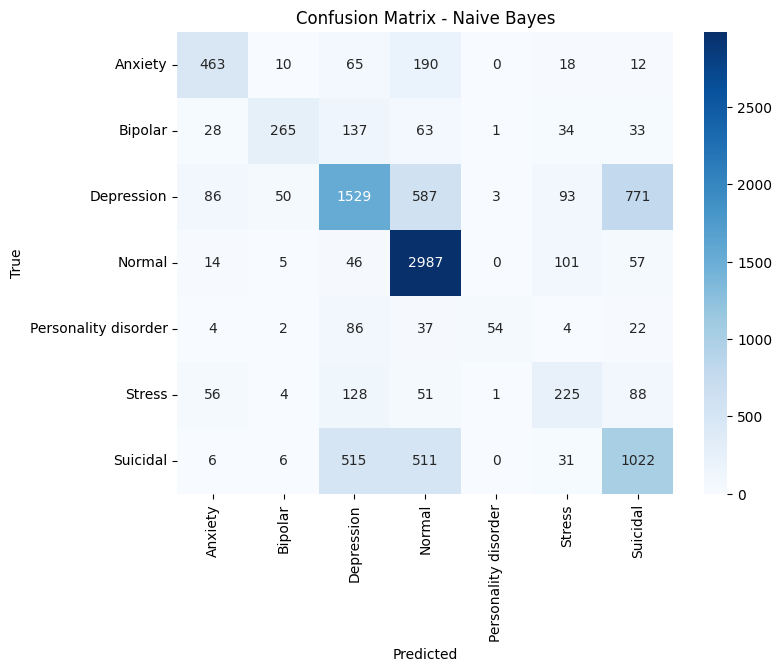

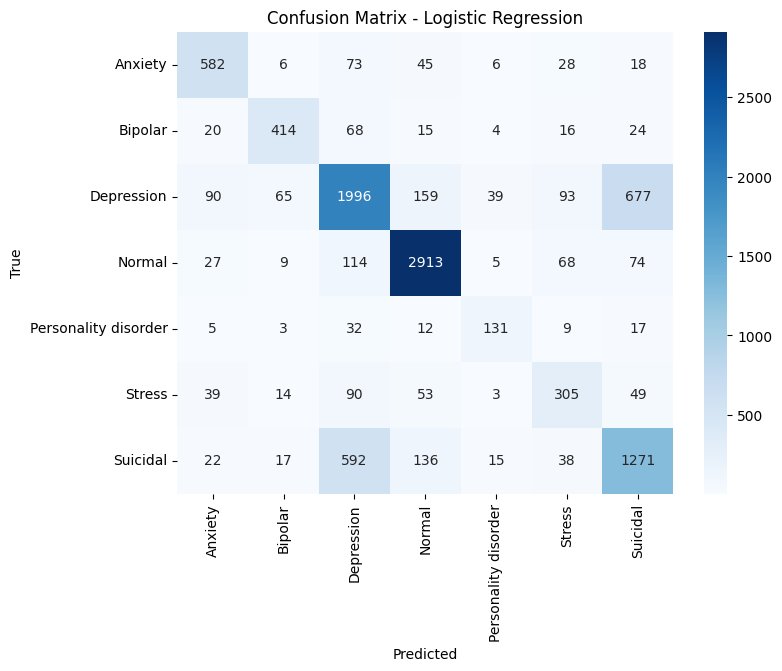

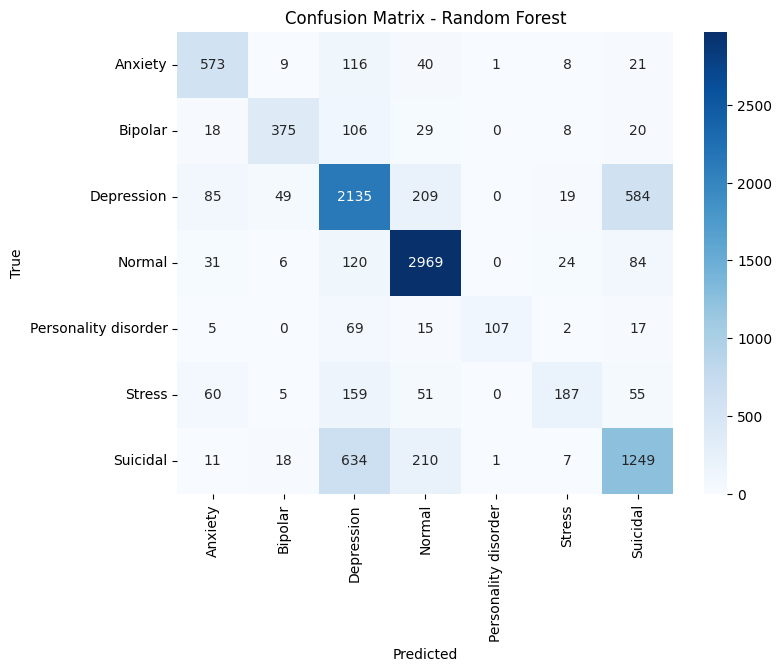

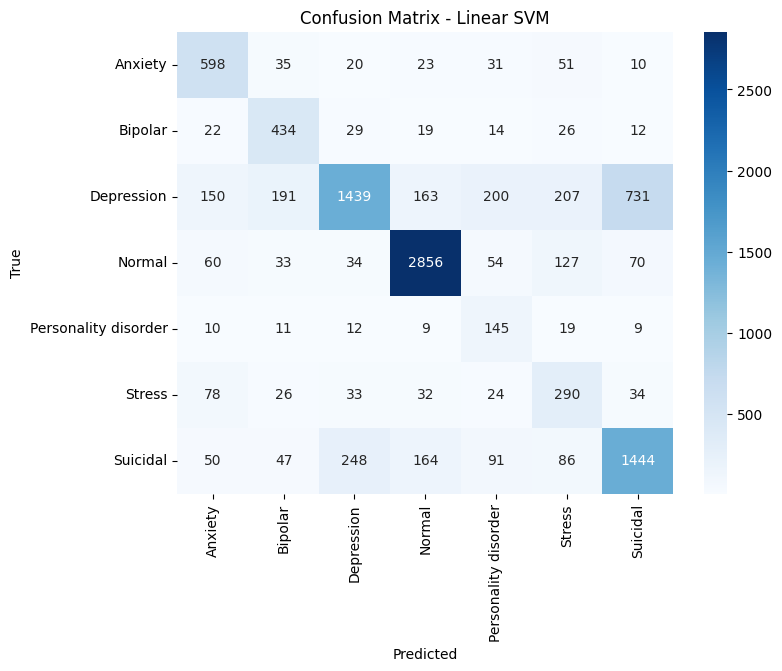

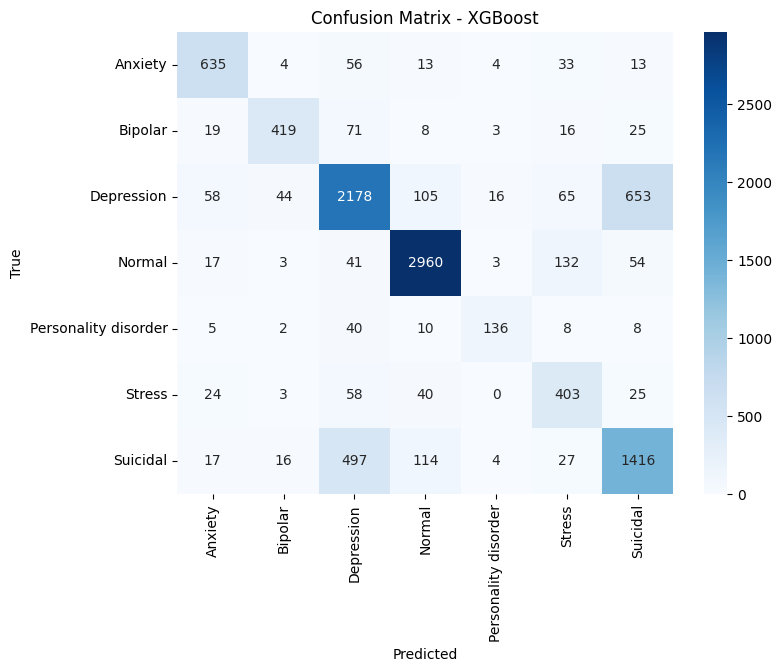

In [26]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression") 
plot_confusion_matrix(y1_test_encoded, y_pred_rf, "Random Forest")
plot_confusion_matrix(y1_test_encoded, y_pred_svm_linear, "Linear SVM")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

In [27]:
df_accuracy

,Accuracy
Naive Bayes,0.623274
Logistic Regression,0.724883
Random Forest,0.723264
Linear SVM,0.686220
XGBoost,0.775831


In [28]:
df_f1

,Naive Bayes,Logistic Regression,Random Forest,Linear SVM,XGBoost
Anxiety,0.654,0.754,0.739,0.689,0.828
Bipolar,0.587,0.760,0.737,0.651,0.797
Depression,0.544,0.656,0.665,0.588,0.719
Normal,0.782,0.890,0.879,0.879,0.916
Personality disorder,0.403,0.636,0.660,0.375,0.725
Stress,0.425,0.550,0.484,0.438,0.652
Suicidal,0.499,0.602,0.600,0.650,0.661


In [29]:
df_precision

,Naive Bayes,Logistic Regression,Random Forest,Linear SVM,XGBoost
Anxiety,0.705,0.741,0.732,0.618,0.819
Bipolar,0.775,0.784,0.812,0.559,0.853
Depression,0.610,0.673,0.639,0.793,0.741
Normal,0.675,0.874,0.843,0.874,0.911
Personality disorder,0.915,0.645,0.982,0.259,0.819
Stress,0.445,0.548,0.733,0.360,0.589
Suicidal,0.510,0.597,0.615,0.625,0.645


In [30]:
df_recall

,Naive Bayes,Logistic Regression,Random Forest,Linear SVM,XGBoost
Anxiety,0.611,0.768,0.746,0.779,0.838
Bipolar,0.472,0.738,0.674,0.781,0.747
Depression,0.490,0.640,0.693,0.467,0.698
Normal,0.931,0.907,0.918,0.883,0.922
Personality disorder,0.258,0.627,0.498,0.674,0.651
Stress,0.407,0.552,0.362,0.561,0.729
Suicidal,0.489,0.608,0.586,0.678,0.677


In [31]:
with open("naive_bayes_model.pkl", "wb") as f:
    pickle.dump(nb_model, f)
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(logreg, f)
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(random_forest, f)
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_linear, f)
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
with open("tfidf1_vectorizer_ml.pkl", "wb") as f:
    pickle.dump(tfidf1, f)
with open("tfidf_vectorizer_ml.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("label_encoder_ml.pkl", "wb") as f:
    pickle.dump(lbl_enc, f)

Machine Learning Model - Input & Prediction Testing

In [32]:
with open("xgboost_model.pkl", "rb") as f:
    xgb = pickle.load(f)

with open("naive_bayes_model.pkl", "rb") as f:
    nb_model = pickle.load(f)

with open("logistic_regression_model.pkl", "rb") as f:
    logreg = pickle.load(f)

with open("random_forest_model.pkl", "rb") as f:
    random_forest = pickle.load(f)

with open("svm_model.pkl", "rb") as f:
    svm_linear = pickle.load(f)

with open("tfidf_vectorizer_ml.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open("tfidf1_vectorizer_ml.pkl", "rb") as f:
    tfidf1 = pickle.load(f)

with open("label_encoder_ml.pkl", "rb") as f:
    label_encoder = pickle.load(f)

test_sentences = [
    "I can't sleep at night and my thoughts won't stop racing.",
    "Lately, I've been feeling so numb and disconnected from everything.",
    "Everything feels fine, just a normal day with coffee and work.",
    "I'm afraid to go outside. The world feels overwhelming.",
    "Sometimes I feel like ending it all. What's the point?",
    "I’m trying to stay strong, but my mood swings are exhausting.",
    "I'm confident, happy, and ready to face the day!",
    "My mind jumps from one idea to another. I can’t stay still.",
    "I don’t even recognize myself anymore. Who am I becoming?",
    "Feeling a bit stressed, but I think I can manage it with deep breaths.",
    "It ends tonight.I can’t do it anymore. I quit.",
    "Is it worth it?Is all the trouble, work and anxiety really worth living for.",
    "do you ever feel empty and you had to pick a number from 15 depending how you feel about it i could write my funeral speech now but what is the point in afew years i would be forgotten anyway",
    "How painful is it and what are the chances of dying from it",
    "I heard from my therapist that anger and depression often go hand in hand, but I feel like it's kinda going off the rails for me. does anyone have more experience with this?",
    "i have been struggling with health anxiety and general spiraling lately, along with a host of other mental health issues. my psychiatrist recommended i try getting back on an antidepressant as they can sometimes help with anxiety (and my healthy dose of depression needs to be managed). we are thinking of prozac since i responded well to it when i was younger..",
    "I found out that in times where my social anxiety was really bad this would also heavily influence my own self confidence and self worth. I would beat myself up for everything I did which made it even harder to overcome my social anxiety. What do you think about this?",
    "I feel like my intrusive thoughts are winning right now, and I feel bad for every thought. I feel like a terrible person and I need to remove myself from everyone because I'm a terrible person and no one would want me around. My inner voice is very mean and I just don't know anymore. I'm just so tired of it all.",
    "The girl that I fell for 10 years ago also suffers from anxiety. I haven't got the guts to let her know how I feel about her. My anxiety recently developed into agoraphobia. I've been improving but I still can't travel far. That kind of demoralized me. My question is: Can a relationship still work if both suffer from anxiety?",
    "Lately I just feel like garbage. I havent left the house much in like 2 weeks, and I've been missing class. It all feels too overwhelming for me, but being at home makes me feel like trash too...I cant win. I cant sleep right either. I wake up every other hour and im so tired...."

]

def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[\U00010000-\U0010FFFF]", "", text)
    allowed_chars = set(string.ascii_letters + "áéíóúãõàâêôç ")
    text = ''.join(c for c in text if c in allowed_chars)
    text = re.sub(r'\s+', ' ', text)
    return text

def preprocess(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer, PorterStemmer

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

for sentence in test_sentences:
    cleaned = preprocess(clean_text(sentence))

    print(f"Original: {sentence}")
    print(f"Cleaned: {cleaned}")
    sequence = tfidf.transform([cleaned])
    sequence2 = tfidf1.transform([cleaned])

    num_features = [[len(sentence), count_sentences(sentence)]]  
    num_features = hstack([sequence, num_features]) 

    tfidf_values = sequence.toarray()[0]
    tfidf_features = tfidf.get_feature_names_out()

    word_tfidf = {word: tfidf_values[i] for i, word in enumerate(tfidf_features) if tfidf_values[i] > 0}  # Only show non-zero values
    # print("TF-IDF Analysis:")
    # for word, tfidf_val in word_tfidf.items():
    #     print(f"  {word}: {tfidf_val:.4f}")

    pred_xgb = xgb.predict(num_features)
    pred_nb = nb_model.predict(num_features)
    pred_logreg = logreg.predict(num_features)
    pred_rf = random_forest.predict(sequence2.toarray())
    pred_svm = svm_linear.predict(sequence2.toarray())

    print(f"XGBoost Prediction: {label_encoder.inverse_transform(pred_xgb)}")
    print(f"Naive Bayes Prediction: {label_encoder.inverse_transform(pred_nb)}")
    print(f"Logistic Regression Prediction: {label_encoder.inverse_transform(pred_logreg)}")
    print(f"Random Forest Prediction: {label_encoder.inverse_transform(pred_rf)}")
    print(f"Linear SVM Prediction: {label_encoder.inverse_transform(pred_svm)}\n")

Original: I can't sleep at night and my thoughts won't stop racing.
Cleaned: cant sleep night thought wont stop race
XGBoost Prediction: ['Normal']
Naive Bayes Prediction: ['Normal']
Logistic Regression Prediction: ['Normal']
Random Forest Prediction: ['Normal']
Linear SVM Prediction: ['Normal']

Original: Lately, I've been feeling so numb and disconnected from everything.
Cleaned: late ive feel numb disconnect everyth
XGBoost Prediction: ['Depression']
Naive Bayes Prediction: ['Normal']
Logistic Regression Prediction: ['Depression']
Random Forest Prediction: ['Normal']
Linear SVM Prediction: ['Depression']

Original: Everything feels fine, just a normal day with coffee and work.
Cleaned: everyth feel fine normal day coffe work
XGBoost Prediction: ['Normal']
Naive Bayes Prediction: ['Normal']
Logistic Regression Prediction: ['Normal']
Random Forest Prediction: ['Normal']
Linear SVM Prediction: ['Anxiety']

Original: I'm afraid to go outside. The world feels overwhelming.
Cleaned: im af